# Lunar orbit propagation with degree 20 spherical harmonics gravity model
In this example, the use of the gravity_sperical_harmonics functions will be demonstrated. Using Goddard Lunar Gravity Model 3, the orbit of a satellite in low Lunar orbit will be propagated. Due to time constraints, relatively low degree and order of the gravity model are used as well as relatively large tolerances in Scipy's RK45 integrator.

In [55]:
# Imports
import matplotlib.pyplot as plt
import pykep as pk
import scipy as sp

In [56]:
# Load the gravity model
r_m, mu_m, c, s, max_degree, max_order = pk.util.load_gravity_model("glgm3_150.txt")

In [57]:
# Define initial orbital parameters
# Cartesian elements for Kepler orbit (a, e, i, raan, aop, ta) = (1.788e06, 0.05, 92, 0, 270, 45)
sat_state0 = sp.array([1.55660045e06,
                       3.35383408e04,
                       -9.60412423e05,
                       9.29725324e02,
                       -4.79891628e01,
                       1.37422982e03])

# Add satellite to propagation list
# states_to_propagate = sp.column_stack((sat0_state0, sat1_state0))
initial_states = sat_state0

In [58]:
# Function to calculate the state derivative.
def propagate(t, state):
    acc = pk.util.gravity_spherical_harmonic(sp.array([state[0:3]]), r_m, mu_m, c, s, 20, 20)
    
    delta_state = sp.array([state[3],
                            state[4],
                            state[5],
                            acc[0, 0],
                            acc[0, 1],
                            acc[0, 2]])
    
    return delta_state

In [59]:
# Run the integration of the orbit.
# Lists to store time and states
time_hist = []
state_hist = []

# Initiate integrator object
integrator = sp.integrate.RK45(propagate, 0, initial_states, 7.5e3, rtol=1e-6, atol=1e-6)

# Scipy goes one step at a time. Loop until the integrator has reached t_bound.
while integrator.status == "running":
    integrator.step()
            
    time_hist.append(integrator.t)
    state_hist.append(integrator.y)
    
state_hist = sp.array(state_hist)

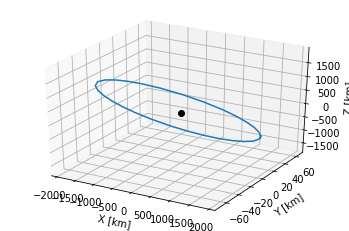

In [61]:
# Plot the orbit

plt.figure(1)
ax = plt.axes(projection='3d')
xline = state_hist[:, 0]/1000
yline = state_hist[:, 1]/1000
zline = state_hist[:, 2]/1000

axis = ax.plot3D(xline, yline, zline)
# Add the central body
axis = ax.plot3D([0], [0], [0], 'ko')

t = ax.set_xlabel("X [km]")
t = ax.set_ylabel("Y [km]")
t = ax.set_zlabel("Z [km]")